# Coursework 1
**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Linear regression and feature selection <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Non-linear regression with Kernel Ridge Regression <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Classification with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data Preprocessing

In [135]:
train_data = pd.read_csv("data/asteroid_observations_train.csv")
test_data = pd.read_csv("data/asteroid_observations_test.csv")
train_data.head()

,Absolute magnitude,Albedo,Number of observations,Observation arc length,Orbital eccentricity,Orbital inclination,Orbital period,Asteroid diameter,Asteroid class
0,18.1,0.041,15,2.0,0.201590,11.975800,3.912298,1.573,MBA
1,12.5,0.139,349,7208.0,0.032746,8.793883,11.942668,12.355,TJN
2,14.1,0.062,705,25309.0,0.179314,27.433960,5.749452,8.862,OMB
3,16.9,0.097,91,3805.0,0.066114,13.813845,4.592982,2.139,MBA
4,11.5,0.062,1300,9606.0,0.008824,5.595907,12.006096,30.763,TJN


In [136]:
# This function is taken from Week 4 tutorial
def standardise(X, X_train_=None):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std

In [137]:
train_arr = train_data.to_numpy()
test_arr = test_data.to_numpy()

X_train = train_arr[:, :-2].astype(float)
y_train_diam = train_arr[:, -2].astype(float)
y_train_class = train_arr[:, -1].astype(str)
X_test = test_arr[:, :-2]
y_test_diam = test_arr[:, -2].astype(float)
y_test_class = test_arr[:, -1].astype(str)


In [138]:

X_train_std = standardise(X_train)
X_test_std = standardise(X_test, X_train)



---



<a name="task-1"></a>

# Task 1: Linear regression and feature selection [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [139]:
N, p = X_train_std.shape
X_aug = np.hstack([np.ones((N,1)), X_train_std]) # augmented training inputs of size N x (p+1)
beta_aug = np.zeros((p+1, 1)) # new beta vector of size (p+1) x 1

In [140]:
# These functions are taken from Week1 Tutorial

def max_lik_estimate(X, y):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (p x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    beta_ml = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_ml

def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y

    return beta_aug_ml

# huber loss
def huber(beta, c = 1e-4):
    return np.where(np.abs(beta) < c, (beta**2)/2.,c * (np.abs(beta) - c/2))

# gradient of huber loss
def grad_huber(beta, c = 1e-4):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c, beta, c * np.sign(beta))



Here one replaces $||\boldsymbol{g}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(g_i)$, where $L_c(g_i)$ is defined as:

$L_c (g_i) =
\begin{cases}
 \frac{1}{2}{g^2_i}                   & \text{for } |g_i| \le c, \\
 c (|g_i| - \frac{1}{2}c), & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.

The piecewise smooth function $L_c (g_i)$ has the gradient:

$\frac{dL_c (g_i)}{dg_i} =
  \begin{cases}
 g_i                   & \text{for } |g_i| \le c, \\
 c\, \text{sign}(g_i) , & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

Now we can minimise the following relaxed function by gradient descent:

$$
\min_{g \in \mathbb{R}^p}
\frac{1}{N}
\sum_{i=1}^{N}
\left(
y^{(i)} - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
\quad
\text{subject to}
\quad
\sum_{j=1}^{p} |g_j| \le s
$$
 is equivalent to
$$
\min_{g \in \mathbb{R}^p}
\left\{
\frac{1}{2}
\sum_{i=1}^{N}
\left(
y_i - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
+
\lambda
\sum_{j=1}^{p} |g_j|
\right\}
$$


Which has the gradient:

\begin{align}
\nabla_{\boldsymbol{g}} L_{\text{Garrote-Huber}}
&= x^T \hat{\beta}^{LS}
+ \lambda \nabla_{\boldsymbol{g}} L_c(\boldsymbol{g})
\end{align}




In [141]:
def minimise_g(x, y, beta_ls_with_int, lam, n_iters=10**4, step_size=1e-7, c_huber=1e-4):
    # x: size Nxp design matrix
    # y: size N vector of diameters
    # beta_ls_wtih_int: size p+1 vector of Least Squares estimators with the intercept beta0 term

    # Split beta into the intercept term and the rest (p terms)
    N = len(y)
    beta_ls = beta_ls_with_int[1::]
    beta0 = beta_ls_with_int[0]

    # Initialise g
    g = np.zeros(len(beta_ls)) + 1

    # Gradient descent to minimise g
    for i in range(n_iters):
        # Compute the gradient of Huber function
        grad_c = grad_huber(g, c=c_huber)


        # Compute the gradient of the regularised loss.
        grad =  beta_ls * (-2 * x.T @ (y - beta0 - x @ (beta_ls * g))) / N + lam * grad_c

        # Update beta
        g -= step_size * grad 

    return g * beta_ls

def fit_garrote(x, beta_g, beta_ls_with_int):
    beta_ls = beta_ls_with_int[1::]
    beta0 = beta_ls_with_int[0]
    y = x @ beta_g + beta0
    return y


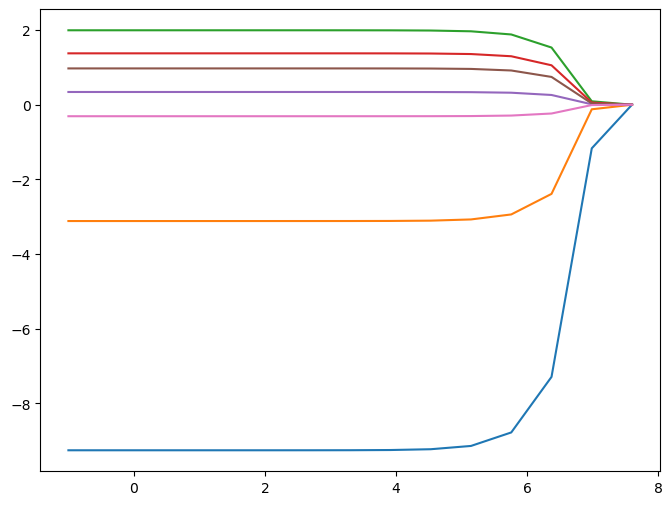

In [142]:
lambdas = np.logspace(-1, 7.6, 15)
log_lambdas = np.log10(lambdas)

N, p = X_train_std.shape
X_aug = np.hstack([np.ones((N,1)), X_train_std]) # augmented training inputs of size N x (p+1)
beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train_diam)

beta_paths = []
for lam in lambdas:
    beta_g = minimise_g(X_train_std, y_train_diam, beta_ls_with_int, lam)
    beta_paths.append(beta_g)

beta_paths = np.array(beta_paths)

plt.figure(figsize=(8, 6))
plt.plot(log_lambdas, beta_paths)




<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [ ]:
fbndms,len


In [153]:

def MSE_t(X, y_train, y_val, lam):

    # Predict fitted values y_hat
    X_aug = np.hstack([np.ones((len(y_train),1)), X]) # augmented training inputs of size N x (p+1)
    beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train)
    beta_g = minimise_g(X, y_train, beta_ls_with_int, lam)
    y_hat = fit_garrote(X, beta_g, beta_ls_with_int)

    # Compute MSE
    MSE = np.mean((y_hat - y_val)**2)

    return MSE

def D(full_X, full_y, T, lam):

    #Split X and Y into T folds
    n = len(full_y)
    indices = np.arange(n)
    fold_indices = np.array_split(indices, T)
    MSEs = []

    for t in fold_indices:
        X = full_X[~t]
        train_y = full_y[~t]
        print(len(train_y))
        val_y = full_y[t]
        print(len(val_y))
        MSEs.append(MSE_t(X, train_y, val_y, lam))
    D = np.mean(np.abs(np.diff(np.array(MSEs))))

    return D

319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
3

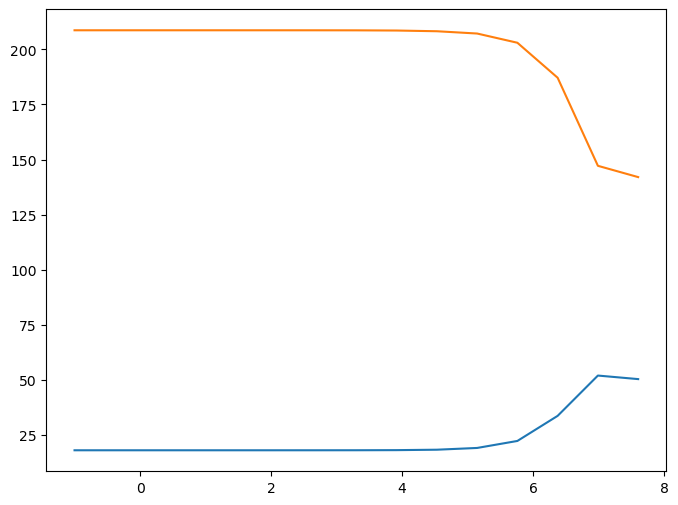

In [154]:
Ts = [2, 20]
Ds = []

for T in Ts:
    Ds.append([])
    for lam in lambdas:
        Ds[-1].append(D(X_train_std, y_train_diam, T, lam))

plt.figure(figsize=(8,6))
plt.plot(log_lambdas, Ds[0])
plt.plot(log_lambdas, Ds[1])

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

<a name="task-2"></a>

# Task 2: Non-linear regression with Kernel Ridge Regression [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

<a name="task-3"></a>

# Task 3: Classification with the Multi-Layer Perceptron [(index)](#index-task-3)

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)